Importing modules...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Savvas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


done in 3.626s.
Parameters used:
 Top features: 500 
 n-grams: (1,1) 
 Cluster number: 7
Loading dataset...
done in 0.067s.
Analyzing answers given for question: 'Comment in English '
Reading dictionaries to be used...
done in 0.075s.
Processing corpus text...
done in 2.103s.
Extracting top features with CountVectorizer and TfidfVectorizer...
done in 0.183s.
  Extracted top 500  features
Isolating answers that do not include any of the top features...
done in 0.164s.
   9 answers out of 866 (1.0%) do not have any of these features.
 These answers are:
   - BBC news app
   - Feeling of Austin has changed
   - Council will listen because you make more $
   - Not gentrifying E.g. Riverside for Newcomers
   - 2005 I sold for $210,000 now is $345,000 or better. I bought the for$ 5000. Taxation is incredible
   - Air that you breathe
   - […] 
   - tutoring centers for children to help them.
   - NONOTE
Processing the rest of the answers ...
done in 0.668s.
Counting answers per features...
d

C:\Users\Savvas\AppData\Local\Temp/ipykernel_14200/579225421.py:981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_answers_df["Cluster_ID"] = unique_class_list
C:\Users\Savvas\AppData\Local\Temp/ipykernel_14200/579225421.py:982: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_answers_df["Score"] = unique_class_score


Preparing viz for features in each cluster...


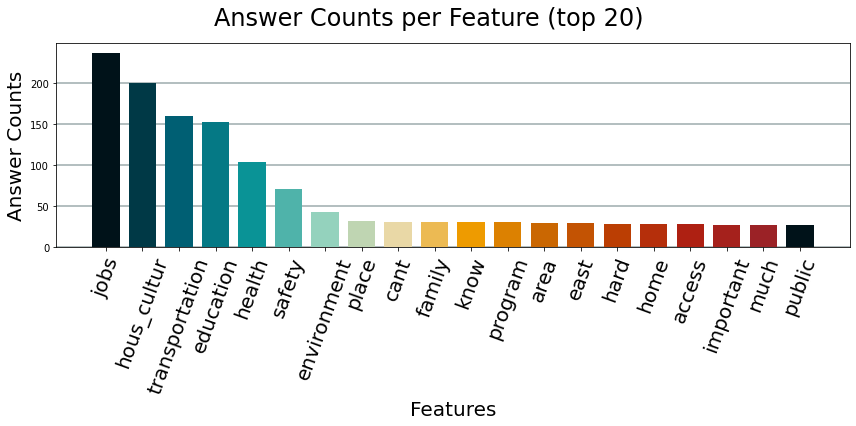

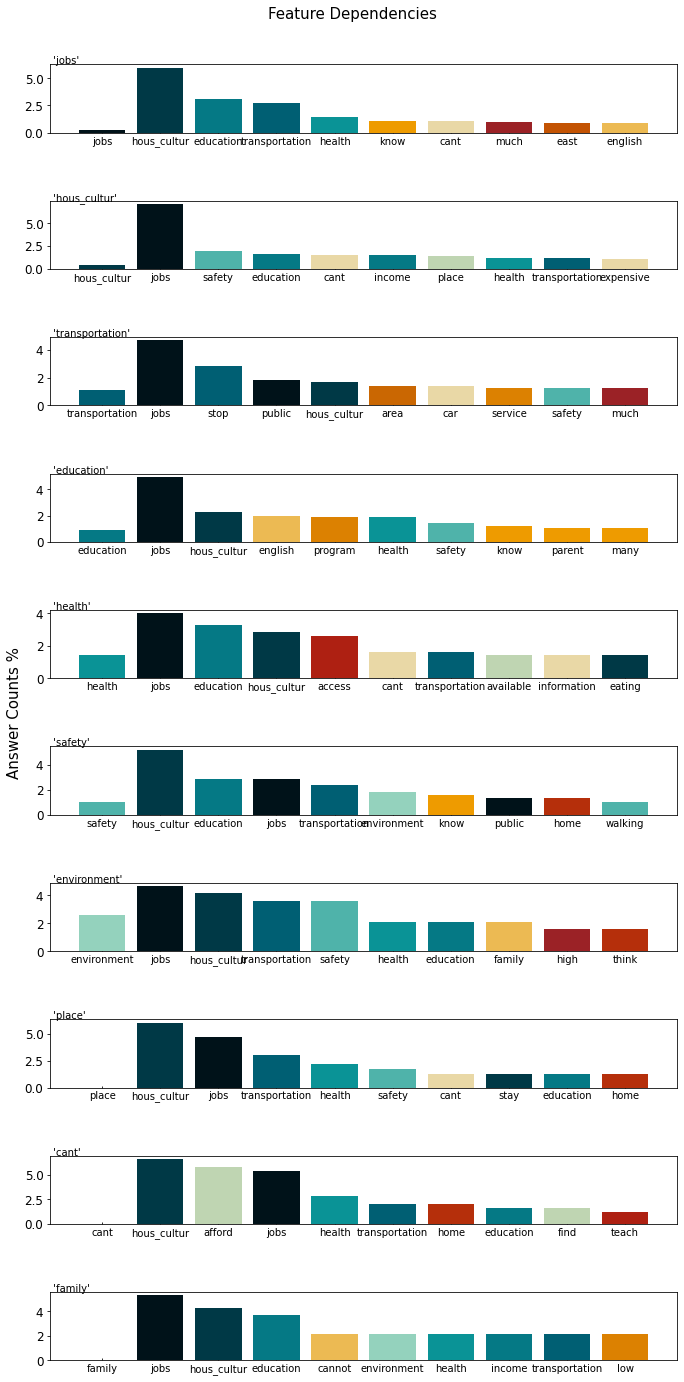

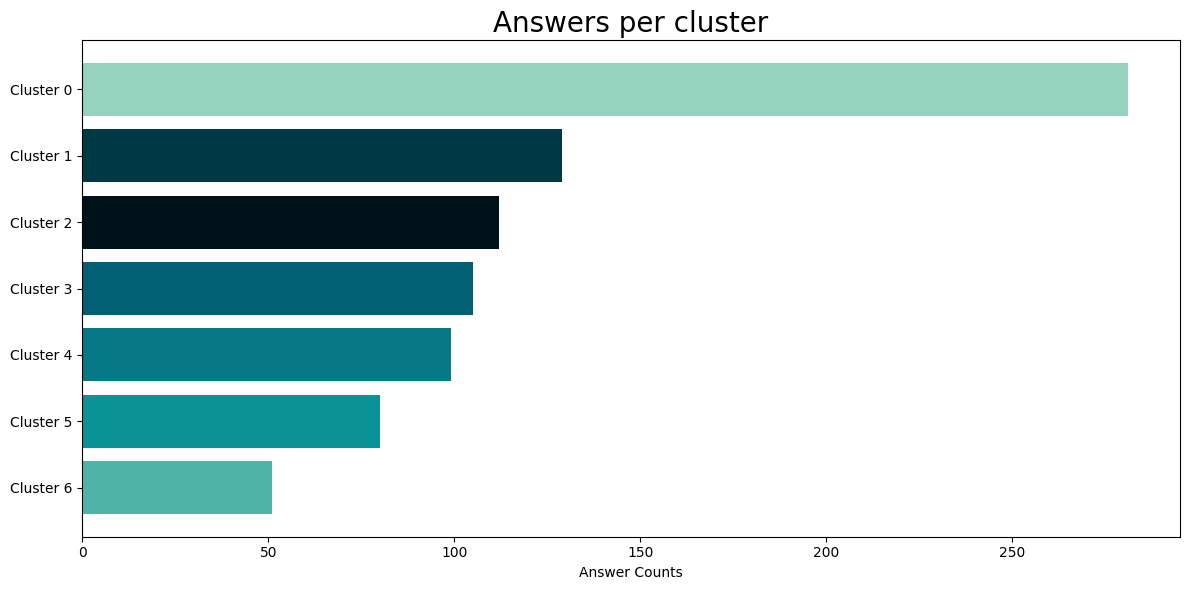

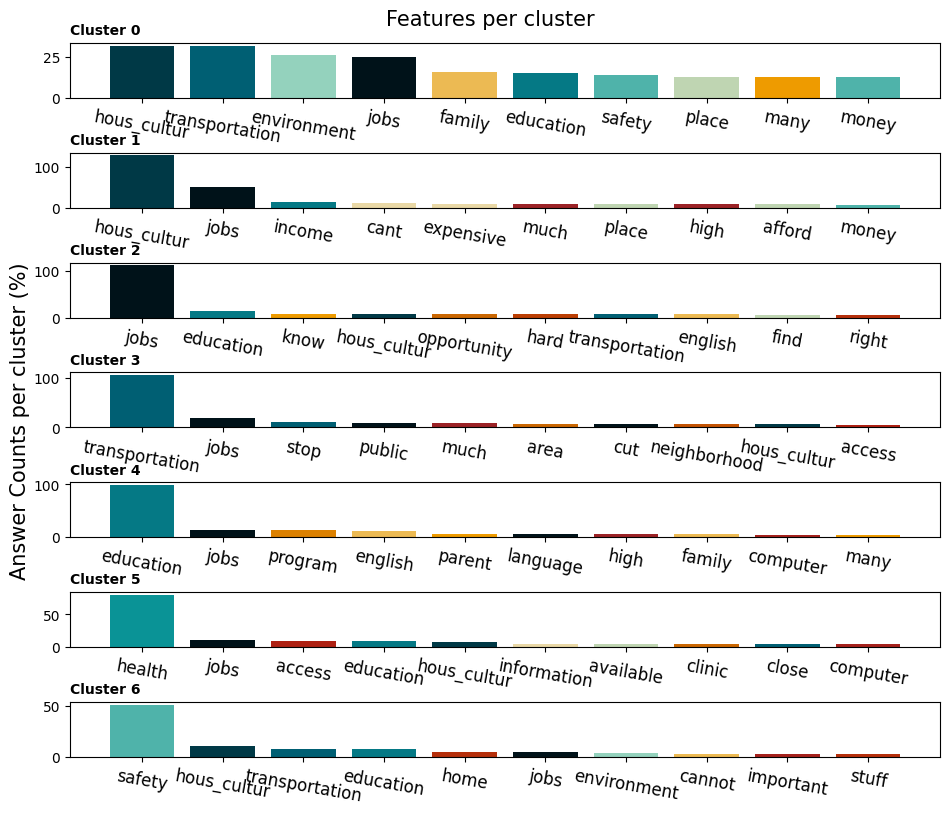

done in 2.750s.
Total running time: 7.8s.


In [1]:
###
#import packages
###
from time import time
print("Importing modules...")
t0 = time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import argparse

#download stopwords list from nltk
nltk.download("stopwords")

print("done in %0.3fs." % (time() - t0))

###
#Define parameters
###

#fig size: 

parameters = pd.read_excel("xlsx_files\parameters.xlsx",header=None)
# print details - usefull when tuning with dictionaries
PRINT_INFO = bool(parameters[1][0])

# number of clusters:
CLUSTER_NO = int(parameters[1][1])

# number of top features to keep
TOP_FEATURES = int(parameters[1][2])
    
# Produce clustering report file named 'clustering_report.xlsx':
REPORT = bool(parameters[1][3])

# Saves identified features in features.xlsx
SAVE_FEATURES = bool(parameters[1][4])

# Option to predict the cluster of a sentence (and it's score)
PREDICT = bool(parameters[1][5])

# Define n-grams:
N_GRAMS_MIN = int(parameters[1][6])
N_GRAMS_MAX = int(parameters[1][7])

#choose porter stemmer (1) or WordNetLemmatizer (2)
PORTER_OR_LEMMATIZER = parameters[1][8]
print(f"Parameters used:\n Top features: {TOP_FEATURES} \n n-grams: ({N_GRAMS_MIN},{N_GRAMS_MAX}) \n Cluster number: {CLUSTER_NO}")

#save vizualizations
SAVE_VIZ = bool(parameters[1][9])


###
#Import data
###
print("Loading dataset...")
t0 = time()
t_start = time()
    
data = pd.read_excel(r"raw_data.xlsx")

###
#modify data
###

#identify the question
Q1 = data.columns.values[0] #Header is the question
#reset index
data.reset_index(inplace=True)
#rename the column index to Q1:
data.rename(columns={Q1: "Answer_text", 'index':'Answer_ID'}, inplace=True) 
data['Answer_ID']= "Q1_"+data['Answer_ID'].astype(str)

#isolate all answers for easier manipulation
Q1_data = data['Answer_text']

print("done in %0.3fs." % (time() - t0))

if PRINT_INFO:
    print (f"Analyzing answers given for question: '{Q1}'")

###
# Dictionaries used
###

print("Reading dictionaries to be used...")
t0 = time()

# topic-dictionary:
#import custom topic-dictionary from topic_dictionary.xlsx
clustering_dict = pd.read_excel(r"xlsx_files\topic_dictionary.xlsx")
#Choose topics from headers
cluster_topics = clustering_dict.columns.values
clustering_dict.fillna('', inplace=True)

# dictionary to replace words with topics:
#keyes -> words to be replaced
#values -> topics to replace keyes
topic_dictionary = {}
for topic in cluster_topics:
    for word in clustering_dict[topic]:
        if len(word)>=1: #dealing with empty columns values
            topic_dictionary.update({word:topic})

# replace terms dictionary:
custom_dictionary = {#various:
                     "/" : " ",
                     "." : " ",
                     "isn't": "is not",
                     "wasn't": "was not",
                     "can't": "can not",
                     "made": "make",
                     "i'm": "i am"
                    }


#join topic_dictionary to custom_dictionary
custom_dictionary.update(topic_dictionary)

#helper function to replace terms
def replace_terms(answer_, two_term = False):
    """
    Using the custom_dictionary, replaces keys of the dictionary with 
    values in a string.
    Args:
        answer_ (string): the string to look for values to replace
        two_term (boolean): if False -> replaces only single words from dictionary
                            if True -> replaces only two words (words separated with space)
    Returns:
        (string): the string with the keys replaced by values
    """
    #replacing words from custom dictionary:
    if two_term:
        for term in custom_dictionary.keys():
            #identify two-word terms
            if " " in term: 
                #if two-word term exist in answer:
                if term in answer_:
                    #replace two-word term in asnwer with dictionary value
                    answer_ = answer_.replace(term,custom_dictionary.get(term)) 
    else:
        for term in custom_dictionary.keys():
            #identify one-word terms 
            if " " not in term:  
                #for tokens in answer
                for i,token in enumerate(answer_): 
                    #if token in term from custom_dictionary
                    if token == term:
                        #replace token with value of dictionary
                        answer_[i] = custom_dictionary.get(term)  
    return answer_

###
# stop-words dictionary
###

# imports words to be deleted from stop_word_list.xlsx
features_01 = pd.read_excel(r"xlsx_files\stop_word_list.xlsx")

# from file, chooses words that are marked with '1' in 'delete' column)
custom_stop_words = list(features_01['features'].loc[features_01['delete'] == 1])

#add to stopwords used
stop_words = set(stopwords.words('english')).union(custom_stop_words)

print("done in %0.3fs." % (time() - t0))
#------------------------#

print("Processing corpus text...")
t0 = time()

###
# Answer processing
###

# punctuation cleaning function
def punct_num_cleaning(answer):
    """
    Cleaning all punctuations

    Args:
        answer (string): single answer from questionaire

    Returns:
        string: answer with no punctuation
    """
    punctuations = "`~!@#$%^&*()-_[{]};:'|,<.>/?01234567890" + '"'
    no_punc = "" 
    # choose only characters from answer that are not in 'punctuations'
    for i, char in enumerate(answer):
        if char not in punctuations:
            no_punc += char 
    return no_punc

# single answer process:
def preprocess_answer(answer):
    """
    preprocess steps:
    - lowercase characters
    - replace values for custom dictionary (2-grams)
    - tokenize
    - remove stop words
    - clean punctuation and numbers
    - replace values for custom dictionary (1-grams)
    - remove stop words

    Args:
        answer (string): single answer from questionaire
    
    Returns:
        list of strings: each string is the result of the above transformations to a word
    """
    #1. lower capital
    answer1 = answer.lower()

    #2. replace values from custom dictionary: #two-term values
    answer2 = replace_terms(answer1, True)

    #3. tokenize
    answer3 = answer2.split()

    #4. remove stopwords:
    answer4 = [word for word in answer3 if word not in stop_words ]

    #5: punctuation cleaning:
    answer5 = [punct_num_cleaning(word) for word in answer4 if len(punct_num_cleaning(word))>0]
    
    #6. replace values from custom dictionary: #one-term values
    answer6 = replace_terms(answer5, False)
    
    #7. remove stopwords:
    answer7 = [word for word in answer6 if word not in stop_words ]

    return answer7


def apply_porter(tokenized_answer):
    """Applying porter stemmer or lemmatizatin to tokenized answers:

    Args:
        tokenized_answer (list of strings): ment to be the output of 
        the preprocess_answer() function to a single string

    Returns:
        a list of strings after porter stemmer or lemmatization has been aplied, 
        and after that the replacement of words in the topic dictionary takes place.
        Necessary because it needs to be applied 3 times to be fully effective
    """
    if PORTER_OR_LEMMATIZER == 1:
        porter = PorterStemmer()
        answer1 = [porter.stem(word) for word in tokenized_answer]       
    elif PORTER_OR_LEMMATIZER == 2:
        lemmatizer = WordNetLemmatizer()
        answer1 = [lemmatizer.lemmatize(word) for word in tokenized_answer]
        
    answer2 = replace_terms(answer1, False)
    return answer2


#single answer process with porter stemmer:
def preprocess_porter_answer(answer):
    """
    Uses preprocess_answer, and additionally porter stemmer on answer

    Args:
        answer (string): _description_

    Returns:
        (list) : list of tokens
    """
    answer1 =  preprocess_answer(answer)
    answer2 = apply_porter(answer1)
    answer3 = apply_porter(answer2)
    answer4 = apply_porter(answer3)
    return answer4




###
#corpus preprocessing
###
def corpus_prep(answers, funct):
    """
   Tokenizes words in each answer.
    
    Args:
        answers (pandas.core.series.Series): a column of pandas df, containing the answers
        funct (function): a function that preprocesses each answer. 
        current options: preprocess_porter_answer / preprocess_answer

    Returns:
        corpus (list) - a list of answers (strings), after being preprocessed. 
                      -> to be used as input in vectorizer    
    
    """
    corpus = []
    # assemble tokens in a string:
    for answer in answers:
        tokenize_answer = funct(answer)
        # answers_w_tokens.append(tokenize_answer)
        string_ = ""
        for token in tokenize_answer: 
            string_ += " " + token
        string_ = string_[1:]
        corpus.append(string_)
    return corpus #, answers_w_tokens

###
# Tokenize corpus
###

# Preprocess answers (to be used with vectorizers)
corpus  = corpus_prep(Q1_data,preprocess_porter_answer)

print("done in %0.3fs." % (time() - t0))


#------------------------#
# test a string to see tokens after processing a text:
# string_test = "Education is the foundation of train schools healthier healthy"
# preprocess_porter_answer(string_test)


print (f'Extracting top features with CountVectorizer and TfidfVectorizer...')
t0 = time()

###
#Calculate count and tfidf weight matrix
###

# create the vectorizer objects for count and tfidf scores
count_vec = CountVectorizer(min_df=2, max_df=.7, ngram_range = (N_GRAMS_MIN,N_GRAMS_MAX), stop_words=stop_words, max_features=TOP_FEATURES)
tfidf_vec = TfidfVectorizer(min_df=2, max_df=.7, ngram_range = (N_GRAMS_MIN,N_GRAMS_MAX), stop_words=stop_words, max_features=TOP_FEATURES)
    # min_df=2: ignore tokens used only once
    # max_df=.9: ingore tokens used in more than 90% of answers
    # ngram_range = (1,1) : deal only with 1-word tokens
    # stop_words=stop_words : use stop_word filtering
    # max_features : choose the top features to create the sentence vector space
    #                optimize by excluded answers 

#instantiate vectorizers with corpus
tfidf_matrix = tfidf_vec.fit_transform(corpus)
count_matrix = count_vec.fit_transform(corpus)


#identify features:
feature_names = tfidf_vec.get_feature_names() # same as count_vector.get_feature_names() 

#cover the case where len(feature_names) < TOP_FEATURES:
if len(feature_names) < TOP_FEATURES:
    TOP_FEATURES = len(feature_names)                                          

word_list_ident= pd.DataFrame()
word_list_ident['Features'] = feature_names

#Optional:  - save features to "features.xlsx"
#           - helpfull when defining stop_word_list.xlsx
if SAVE_FEATURES:
    word_list_ident.to_excel("features.xlsx")

#Prepare answer-feature count array and df: *multiple features allowed per answer
count_array = count_matrix.toarray()
count_df = pd.DataFrame(data=count_array, columns = count_vec.get_feature_names())

#prepare answer counts per feature: *binary answer counts per feature
binar_array = np.array(count_array, copy=True)
binar_array[binar_array != 0] = 1  # correct for small numbers
binar_df = pd.DataFrame(data=binar_array, columns = count_vec.get_feature_names())


#Prepare answer-tfidf array to df:
answer_tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

print("done in %0.3fs." % (time() - t0))

#Optional: show number of features 
if PRINT_INFO:
    print ("  Extracted top",TOP_FEATURES," features")


#------------------------#
print ('Isolating answers that do not include any of the top features...')
t0 = time()
def get_zero_vector_indexes():
    """
    Identify index of answers with zero vectors

    Returns:
        (list): a list of indexes for answers with zero vectors
    """
    zero_index = []
    #loop through answers
    for i in range (0, len(Q1_data)):
        #find index of all zero_vector answers:
        if answer_tfidf_scores.iloc[i].sum() == 0:
            #add answer index to list
            zero_index.append(i)
    return zero_index

#Identify zero vector answers by index:
zero_index = get_zero_vector_indexes()
                
# identify zero-vector answer text:
unique_answers_df = data[data.index.isin(zero_index)]
unique_answers = unique_answers_df['Answer_text']

# choose non-zero-vectors from answer_tfidf_scores, count_df and binar_df for later use
tfidf_vectors = answer_tfidf_scores[~answer_tfidf_scores.index.isin(zero_index)].reset_index(drop = True)
count_vectors = count_df[~count_df.index.isin(zero_index)].reset_index(drop = True) #counts feature encounters per answer
binar_vectors = binar_df[~binar_df.index.isin(zero_index)].reset_index(drop = True)

# choose answer text for non-zero tfidf vectors:
non_zero_answers_df = data[~data.index.isin(zero_index)].reset_index(drop = True)
non_zero_answers = non_zero_answers_df['Answer_text']
print("done in %0.3fs." % (time() - t0))

#Optional: show excluded answers 
if PRINT_INFO:
    unique_ans_percent = round(len(unique_answers)/len(Q1_data)*100,1)
    print (f"   {len(unique_answers)} answers out of {len(Q1_data)} ({unique_ans_percent}%) do not have any of these features.")
    if unique_ans_percent > (20):
        print (f'   {unique_ans_percent}% could be high. Verify that these answers do not contain any usefull information')
    print (' These answers are:')
    for unique_answer in unique_answers:
        print ("   -",unique_answer)
    
#------------------------#

print("Processing the rest of the answers ...")
t0 = time()

def get_feature_names_and_counts(df_binar):
    """
    From a dataframe that includes binary values for some features,
    returns two lists, one for features and one for counts per feature

    Args:
        df_binar (dataframe): a dataframe of binary values for a list of features

    Returns:
        features_sorted (list) : names of features, sorted according to answer counts for each feature
        features_sorted_count_list (list) : counts for each feature, with same sorting
    """
    # sort features according to feature binary counts - (list of stings)
    features_sorted = list(df_binar.sum().sort_values(axis=0, ascending=False).index)
    # make a list of counts of each feature (list of int)
    features_sorted_count_list = df_binar.sum().sort_values(axis=0, ascending=False).tolist()
    return features_sorted, features_sorted_count_list    
    
    
features_sorted, features_sorted_count_list = get_feature_names_and_counts(binar_vectors)


###
#Define colors for each feature:
###
colors_10 = ["#001219", '#005F73', '#0A9396', '#94D2BD', '#E9D8A6', '#EE9B00', '#CA6702', '#BB3E03', '#AE2012', '#9B2226']
colors_19 = ["#001219", '#003946','#005F73', '#057985','#0A9396', '#4FB3AA','#94D2BD','#BFD5B2' ,'#E9D8A6', '#ECBA53','#EE9B00', '#DC8101','#CA6702', '#C35303', '#BB3E03','#B52F0B', '#AE2012', '#A5211C', '#9B2226']
def set_feat_colors(feature_list, color_list = colors_19):
    """
    Creates a list of colors, one for each feature, based on a color_list.
    If features are more than the colors in the color list, then colors are 
    repeated, starting from color_list[1] until the last color of the color list.
    
    colors_10 pallete:  includes 10 colors that are distinguishable by people with 
                        deuteranopia 

    Args:
        feature_list (list): a list of features
        color_list (list, optional): a list of colors

    Returns:
        feat_colors(list): a list of colors, one for each feature. 
    """
    feat_colors = []
    for i in range(len(feature_list)):
        color_index = i % len(color_list)
        feat_colors.append(color_list[color_index])
    return feat_colors

# create a color list for each feature according to features_sorted:
feature_colors = set_feat_colors(features_sorted)

# create a feature_color dictionary
feature_color_dict = dict(zip(features_sorted, feature_colors))

###
# Bar chart: Top N features Vs Answer Counts
###

def plot_feature_count(top_N, sorted_features, sorted_features_count_list):
    """
    Prepares a barchart of top N features, showing answer count
    for each feature

    Args:
        N (int): top N features to show in the bar chart. 
                cannot be larger than TOP_FEATURES defined in Parameters
    """
    if top_N > TOP_FEATURES:
        top_N = TOP_FEATURES    
    labels = sorted_features[0:top_N]
    data = sorted_features_count_list[0:top_N]
    wdth = 0.75
    plt.figure(figsize=(12, 6))
    plt.rcParams['axes.axisbelow'] = True
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Features',fontsize='20')
    plt.ylabel('Answer Counts',fontsize='20')
    plt.rcParams['axes.axisbelow'] = True
    plt.suptitle(f'Answer Counts per Feature (top {top_N})',fontsize='24')
    plt.grid(color='#95a5a6', linestyle='-', linewidth=2, axis='y', alpha=0.7)
    plt.bar(range(len(data)),  data, width = wdth, color = [feature_color_dict[i] for i in labels]) 
    plt.xticks(rotation = 70,fontsize='20')
    plt.subplots_adjust(bottom = 0.2)
    plt.tight_layout()
    if SAVE_VIZ:
        plt.savefig("features_count.png")
    
    
    
###
# Feature dependencies analysis:
###
    
def get_feature_N_answers_df(N):
    """
    Isolates all answers that include the feature with index N from the 
    features_sorted list

    Args:
        N (int): Position of feature from the features_sorted list

    Returns:
        feature_N_answers_df (df):  part of the binar_df that includes only
                                    answers with the chosen feature 
    """
    feature_N = features_sorted[N]
    feature_N_answers_df = binar_df.loc[binar_df[features_sorted[N]] != 0]
    return feature_N_answers_df


#isolate answers that include feature N:
def feature_N_dependencies(N):
    """
    Analyzes answers that include a specific feature (feature with index N, from sorted_features).
    This is done in order to later identify other features that are combined in those answers, 
    and identify which features are used together.

    Args:
        N (int): number of feature (from 'features_sorted') to identify dependencies from other features

    Returns:
        four outputs, in the following order:
            - feature_N (string): feature name
            - N_feature_feature_names (list): names of the features with the same order as norm_featN_counts
            - norm_only_featN_count (number): counts of answers that include only feature N
                                            and are independent from other features, normalized to 100
            - norm_featN_counts (list): counts of all the other features, sorted, and normalized to 100

    """
    feature_N = features_sorted[N]
    feature_N_vectors = binar_vectors.loc[binar_vectors[features_sorted[N]] != 0]
    feature_N_indexes = np.array(feature_N_vectors.index.values.tolist())
    feature_N_sums = feature_N_vectors.to_numpy().sum(axis=1)

    #count answers that include only feature N, and no other feature:
    # answers that their vertical sum is 1:
    only_N_feature_counts = np.count_nonzero(feature_N_sums == 1)

    #count answers for all features:
    feature_N_feat_sums = feature_N_vectors.to_numpy().sum(axis=0)

    #sort answer counts per feature, for answers that include feature N:
    feature_N_feat_sums_sorted = np.sort(feature_N_feat_sums)
    feature_N_feat_sums_sorted = np.flip(feature_N_feat_sums_sorted)
    #sort feature indexes accordingly
    sorted_indexes_for_N = np.argsort(feature_N_feat_sums)
    sorted_indexes_for_N = np.flip(sorted_indexes_for_N)
    #make a list of the sorted feature names included in answers that include feature N: 
    N_feature_feature_names = [feature_names[i] for i in sorted_indexes_for_N]
    
    #exclude count for feature N from array:
    feature_N_feat_sum_cleaned = np.delete(feature_N_feat_sums, feature_names.index(features_sorted[N]),0)

    #normalize counts for bar graph:
    const = 100/(feature_N_feat_sum_cleaned.sum()+only_N_feature_counts)
    norm_featN_counts = list(feature_N_feat_sums_sorted * const)
    norm_only_featN_count = only_N_feature_counts*const
    #exclude feature N from the feature names:
    ind_removed = N_feature_feature_names.index(feature_N) 
    N_feature_feature_names.remove(feature_N)

    del norm_featN_counts[ind_removed]
    #prepare final list:
    ##first number will be that of feature N counts only
    N_feature_feature_names.insert(0, feature_N)

    norm_featN_counts.insert(0,norm_only_featN_count)
    
    return N_feature_feature_names,  list(norm_featN_counts)

###
#create list of lists that include the dependency value percentages for each feature
###
feat_dependencies_counts_list = []
feat_dependencies_names_list = []
feat_dependencies_color_list = []
for i in range (TOP_FEATURES):
    feat_names, feat_counts = feature_N_dependencies(i)
    feat_dependencies_counts_list.append(feat_counts)
    feat_dependencies_names_list.append(feat_names)
    feat_dependencies_color_list.append([feature_color_dict.get(i)for i in feat_names])
    
#convert them to an array, for easy manipulation/slicing:
feat_dependencies_color_array = np.array(feat_dependencies_color_list)


###
#Analyze dependencies between features:
###

def get_depend_data_bar(keyword_no):
    """
    Calculates the keyword dependencies for a specific keyword:
      For answers that include one feature, what other features are found.
    

    Args:
        keyword_no (int): this is the number of a keyword from
        a list of features_sorted.

    Returns:
        Four values ment to be used in generating a bar graph for keyword dependencies for a keyword:
            graph_title (string) : name of the keyword being analyzed
            counts_per_feature (list of int) : counts of answers that include the x_labels keywords
            x_labels (list of strings) : keywords that are included in answers that have the chosen keyword 
            bar_colors (list of colors) : a list of colors that are assigned to each keyword
    """
    graph_title = features_sorted[keyword_no]
    counts_per_feature = feat_dependencies_counts_list[keyword_no]
    x_labels = feat_dependencies_names_list[keyword_no] #feature names
    bar_colors = list (feat_dependencies_color_array[keyword_no])
    return graph_title, counts_per_feature, x_labels, bar_colors
    

def keyword_dependencies_viz(keyword_no = 10):
    """
    Make multiple bar chartd showing the dependencies between features.
    The first bar shows only the number of independent answers 
        i.e. the number of those answers that do not include any other 
        features from the top features defined 

    Args:
        keyword_no (int, optional): _description_. Defaults to 10.
    """
    
    plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=12) #fontsize of the x tick labels
    fig, axs = plt.subplots(keyword_no, 1, figsize = (10,20))

    if keyword_no > TOP_FEATURES:
        keyword_no = TOP_FEATURES
    #make the graph for every keyword:
    
    for i in range (keyword_no):
        graph_title, counts_per_feature, x_labels, bar_colors = get_depend_data_bar(i)
        axs[i].bar(x_labels[0:keyword_no], counts_per_feature[0:keyword_no], color = bar_colors[0:keyword_no])
        axs[i].set_title(f" '{graph_title}'", y =0.92, loc = 'left', fontsize=10)
        axs[i].tick_params(axis='x',direction='in', length=2)

    
    fig.subplots_adjust(left=0.08, right=0.95, top=0.95,bottom = 0.05,hspace = 1)
    fig.suptitle("Feature Dependencies", x=0.5,y=0.99,  fontsize= 15)
    fig.supylabel('Answer Counts %', fontsize= 15)
    # Show the plot
    #fig.tight_layout()
    if SAVE_VIZ:
        plt.savefig(f"top_{keyword_no}_feature_dependencies.png")
    #plt.show()
    
    
print("done in %0.3fs." % (time() - t0))

print("Counting answers per features...")
t0 = time()
#Make a bar plot showing counts for top 20 features:
plot_feature_count(20, features_sorted, features_sorted_count_list )
print("done in %0.3fs." % (time() - t0))



print("Analyzing correlations for top 10 features...")
t0 = time()
#Make a bar plot for each of the keywords, showing their dependencies on other keywords:
keyword_dependencies_viz()
print("done in %0.3fs." % (time() - t0))



print("Performing clustering...")
t0 = time()
kmeans = KMeans(n_clusters=CLUSTER_NO, init = 'k-means++', random_state = 42)
kmeans.fit_predict(tfidf_vectors)

# identify arrays for each cluster centroid
cluster_centroids = kmeans.cluster_centers_  #not normalized

#sort indices of features for each cluster in descending order 
order_centroids = cluster_centroids.argsort()[:, ::-1]

#cluster for each answer:
cluster_answer_array = kmeans.labels_

#clusters and answer counts per cluster:
cluster_numbers , answers_per_cluster = np.unique(cluster_answer_array, return_counts=True)

#identify max number of answers in a cluster:
max_number_of_answers_per_cluster = answers_per_cluster.max()

#sorting numbering of clusters based on counts per cluster
#     cluster with max answers should be cluster 0
idx_to_sort_cluster_counts = np.argsort(-answers_per_cluster)
answers_per_cluster_after_sorting = answers_per_cluster[idx_to_sort_cluster_counts]
cluster_numbers_sorted = cluster_numbers[idx_to_sort_cluster_counts]
before_to_after_sorting_clust_no_dic = dict(zip(cluster_numbers_sorted, cluster_numbers))
cluster_answer_array_after_sorting  = np.array([before_to_after_sorting_clust_no_dic[i] for i in list(cluster_answer_array)])

#cluster_answer_array_after_sorting  = np.array([cluster_numbers_after_sorting[i] for i in list(cluster_answer_array)])

cluster_centroids_after_sorting = cluster_centroids[list(cluster_numbers_sorted)]
order_centroids_after_sorting = cluster_centroids_after_sorting.argsort()[:, ::-1]
print("done in %0.3fs." % (time() - t0))

answers_per_cluster = answers_per_cluster_after_sorting 
#cluster_numbers = cluster_numbers_after_sorting
cluster_answer_array = cluster_answer_array_after_sorting
cluster_centroids = cluster_centroids_after_sorting
order_centroids = order_centroids_after_sorting 

print("Analyzing feature contributions for each cluster...")
t0 = time()

#Normalize cluster_centroids -> 'l2' normalization
normalized_cluster_centers = normalize(cluster_centroids)

#create a df with top 5 features for each cluster
cluster_top_features = pd.DataFrame()
#create a df with the contributions of each feature to the cluster
cluster_graded_features = pd.DataFrame()
for i in range(CLUSTER_NO):  #for each cluster
    feature_list = []
    feature_grade = []
    for ind in order_centroids[i, :5]: #for each feature index from top 5 in cluster centroid 
        ind_feature = str('%s' % feature_names[ind]) #choose the feature index name
        ind_feature_grade = normalized_cluster_centers[i][ind] #choose the tfidf value of the feature given in normalized_cluster_centers 
        feature_list.append(ind_feature)
        feature_grade.append(round(ind_feature_grade*ind_feature_grade*100)) #square the grade and express that as a % 
    #add the lists to a column for i cluster
    cluster_top_features[str(i)] = feature_list
    cluster_graded_features[str(i)] = feature_grade
    

###
# Identify answers per cluster:
###

# create a df with answers and cluster_no
answers_with_cluster_no_df = pd.DataFrame()
answers_with_cluster_no_df["answers"]= non_zero_answers
answers_with_cluster_no_df["clusters"] = cluster_answer_array
non_zero_answers_df['clusters'] = cluster_answer_array

# create a df that includes answers per cluster
answer_per_cluster = pd.DataFrame()
for i in range(CLUSTER_NO):
    answer_list = list(answers_with_cluster_no_df["answers"].loc[answers_with_cluster_no_df['clusters'] == i]) #non_zero_answers_df['clusters']
    while len(answer_list) < max_number_of_answers_per_cluster: #make sure the number of columns is the same for all clusters
        answer_list.append(" ")
    answer_per_cluster[str(i)] = answer_list

###
# count answers per top feature, for each cluster
# ###

# create a df for feature counts percent per cluster:
feature_counts_percent = pd.DataFrame()
for k in range(CLUSTER_NO):
    #identify indexes of top 5 features for cluster k in a list
    top_feat_idx = list(order_centroids[k][0:5])
    #choose top 5 features from the count_vector and reset index
    temp_df = count_vectors[count_vectors.columns[top_feat_idx]].reset_index(drop=True)   
    #identify indexes for answers per cluster:
    cluster_answer_idx = answers_with_cluster_no_df.index[answers_with_cluster_no_df['clusters'] == k].tolist()
    #get answers_frequency only for cluster
    temp_df = temp_df.loc[cluster_answer_idx]
    #count answers for top 5 features and normalize to percent
    test = round(temp_df.astype(bool).sum(axis=0) / answers_per_cluster[k] * 100)
    feature_counts_percent[str(k)] = list(test)
    
clustering_info = pd.concat([
                             pd.DataFrame([answers_per_cluster_after_sorting], columns = [str(i) for i in range(CLUSTER_NO)]),
                             pd.DataFrame(cluster_top_features,columns = [str(i) for i in range(CLUSTER_NO)]),
                             pd.DataFrame(feature_counts_percent,columns = [str(i) for i in range(CLUSTER_NO)]),
                             pd.DataFrame(cluster_graded_features,columns = [str(i) for i in range(CLUSTER_NO)]),
                            ],keys = ['answer counts',
                                      'top_5_features',
                                      'answer_counts_per_feature_(%)',
                                      'feature_contribution_(%)'])

print("done in %0.3fs." % (time() - t0))

print (clustering_info)
#------------------------#
###
# functions to calculate sentence similarity to cluster:
###


# function to calculate the tfidf vector for any string
def calc_tfidf_vector(answer):
    """
    Calculates the tfidf score for a single answer, based on terms and 
    number of answers used from the vectorizer

    Args:
        answer (sting): a single answer, to calculate it's tfidf vector

    Returns:
        np.array : the tfidf array of the answer, based on the intance of
                   the vectorizer used for clustering
    """
    # this function uses the following variables defined elsewhwere:
    # - the features used for clustering (feature_names),
    # - the original corpus of answers (corpus)
    # - the instance of the intantieated vectorizer used in the corpus
    # - the instance of the tfidf vectorizer used () 
    
    #preprocess answer:
    processed_answer = preprocess_porter_answer(answer)
    
    #join the tokens:
    answer_for_corpus = ''
    for token in processed_answer:
        answer_for_corpus = answer_for_corpus + ' ' + token
    
    #calcualte tfidf score for answer
    answer_vector = tfidf_vec.transform([answer_for_corpus]).toarray()
    
    return answer_vector

#function to calculate euclidean distance
def calc_eucl_dist(U1, U2):
    """Calculates the euclidean distance between two vectors.
    Args:
        vector1 (np.array): tfidf vector of a cluster
        vector2 (np.array): cluster centroid vector

    Returns:
        (np.array) : _description_
    """
    eucl_dist = np.sqrt(np.sum(np.square(np.array(U1) - np.array(U2))))
    return eucl_dist

#function to find cluster with minimum distance
def find_cluster(answer):
    answer_vector = calc_tfidf_vector(answer)
    #evaluate if answer is in Unique class: 
    if answer_vector.sum() == 0.0:
        cluster = 'U'
        score = ' '
        cluster_name = 'Unique'
    else:
        #define a large number (should be bigger than 2)
        min_dist = 123456789
        for i,centroid in enumerate(normalized_cluster_centers):
            dist = calc_eucl_dist(centroid, answer_vector)
            if dist < min_dist:
                cluster = str(i)
                cluster_name = cluster_top_features[str(i)][0]
                min_dist = dist
        # calculate score: (min dist should have largest score, larger distance should have minimum score)
        # minimum dist value: 0, 
        # max dist value: 1
        score = (2-min_dist)/2*100
    return cluster, score, cluster_name

# function to accept a string as input, calculate it's cluster, and it's score
def enter_sentence():
    """
    test any sentence to identify it's cluster and the corresponding score 
    """
    # define a looping variable
    try_it = True
    while try_it:
        #input a variable
        test_it = input('Do you want to find a cluster for a sentence? (Y/N)')
        #if Y:
        if test_it == "Y":
            # write a sentence
            test_string = input('Please write a sentence:')
            # find the cluster and the score
            cluster_, score_, cluster_name = find_cluster(test_string)
            # if answer is unique return only U
            if cluster_ == 'U':
                print (f'{test_string}:')
                print ("Answer does not belong to any cluster")
            # else find the cluster and the score 
            else:
                print (f'{test_string}:')
                print (f'belongs to cluster {cluster_}, "{cluster_name}" with a score of {score_}.')
        elif test_it == "N":
            try_it = False
        else:
            print ('Please choose a valid option, Y or N')
    return  

# function to calculate the score of each answer in a cluster
def cluster_answer_score(i):
    """returns an array with scores for answers of a cluster. The score is 
    calculated as the euclidean distance between each answer_vector and the 
    cluster centroid, normalized to 100

    Args:
        i (number): number of cluster

    Returns:
        dataframe : 1 column with "Score" for each answer
    """
    score_per_answer_df = pd.DataFrame()
    #choose centroid for each cluster
    centroid_vector = normalized_cluster_centers[i]
    #choose indexes from non_zero answer list
    cluster_idxes = list(np.where(cluster_answer_array==i)[0])
    #choose Cluster_ID/Answer_ID/Answer_text based onn cluster_idxes:
    score_per_answer_df['Cluster_ID'] = non_zero_answers_df['clusters'].iloc[cluster_idxes]
    score_per_answer_df['Answer_ID'] = non_zero_answers_df['Answer_ID'].iloc[cluster_idxes]   
    score_per_answer_df['Answer_text'] = non_zero_answers_df['Answer_text'].iloc[cluster_idxes]
    # choose tfidf vectors for all answers of cluster
    cluster_tfidf_vector = np.array(tfidf_vectors.iloc[cluster_idxes])
    #calculate_eucledean_dist between each vector and normalized centroid
    scores = []
    for vector in cluster_tfidf_vector:
        eucl_dist = calc_eucl_dist(vector ,centroid_vector)
        scores.append(eucl_dist)
        #normalize to 100 (2 is the max euclidean distance with normalized vectors):
    score_array = (2-np.array(scores))/2*100
    #score_per_answer_df['answer_idx'] = cluster_idxes
    score_per_answer_df['Score'] = score_array
    return score_per_answer_df.reset_index(drop=True)


###
#Prepare a df with: [Cluster_id],[Answer_id], [Answer_text], [Score] 
###

#For each cluster:
clustered_data = pd.DataFrame()
for i in range (CLUSTER_NO):
    #calculate the score for all answers
    temp_df = cluster_answer_score(i)
    #add score of cluster to df of all clusters' score
    clustered_data = pd.concat([clustered_data,temp_df])
clustered_data.reset_index(drop=True)

#add unique_answers:
#model clusters them as U cluster, and it has no score
unique_class_list = ['U']*len(unique_answers_df)
unique_class_score = ['-']*len(unique_answers_df)
unique_answers_df["Cluster_ID"] = unique_class_list
unique_answers_df["Score"] = unique_class_score
unique_answers_df
clustered_data = pd.concat([clustered_data,unique_answers_df])


###
#Assemble a df with: [Cluster_id],[Answer_name], [question], [question_text]
###

#create df final columns
cluster_summary = pd.DataFrame(columns = ['Cluster_id','Cluster_name','Question','Question_text'])
for i in range (CLUSTER_NO):
    #fill it column by column
    #i = int(before_to_after_sorting_clust_no_dic[str(ii)])
    temp_df = pd.DataFrame()
    temp_df['Cluster_id'] = [i]
    #choose the top feature to be the cluster name:
    temp_df['Cluster_name'] = [clustering_info.iloc[1][i]]
    temp_df['Question'] =[data['Answer_ID'][0].split('_')[0]]
    temp_df['Question_text'] = [Q1]
    cluster_summary = pd.concat([cluster_summary,temp_df])
cluster_summary.sort_values(by=['Cluster_id'], inplace = True)

#dealing with unique answers:
unique_summary = pd.DataFrame()
unique_summary['Cluster_id'] = ["U"]
unique_summary['Cluster_name'] = ['Unique_Answers']
unique_summary['Question'] =[data['Answer_ID'][0].split('_')[0]]
unique_summary['Question_text'] = [Q1]

cluster_summary = pd.concat([cluster_summary,unique_summary])

###
#prepare final xlsx file with the three dfs as sheets:
###

with pd.ExcelWriter("Clustered_data.xlsx") as writer:
    clustered_data.to_excel(writer, sheet_name="Question_1", index=False)
    cluster_summary.to_excel(writer, sheet_name="model", index=False)
    clustering_info.to_excel(writer, sheet_name="clustering_report", index = True)
    
cluster_id_array = (cluster_summary['Cluster_id']).to_numpy()[:-1]
cluster_name_array = (cluster_summary['Cluster_name']).to_numpy()[:-1]
sorted_idx = np.argsort(answers_per_cluster)

cluster_id_array_sorted = cluster_id_array[sorted_idx]
cluster_name_array_sorted = cluster_name_array[sorted_idx]
answers_per_cluster_sorted = answers_per_cluster[sorted_idx]
def clusters_count_viz():
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(12, 6))
    # Example data
    y_pos = np.arange(len(answers_per_cluster))
    cluster_label = cluster_name_array_sorted
    ax.barh(y_pos, answers_per_cluster_sorted, align='center', color = [feature_color_dict[str(i)] for i in cluster_label])
    ax.set_yticks(y_pos, labels= ["Cluster "+str(len(cluster_label)-i-1) for i in range (len(cluster_label))])
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Answer Counts',fontsize='10')
    ax.set_title('Answers per cluster',fontsize='20')
    plt.tight_layout()
    if SAVE_VIZ:
        plt.savefig("cluster_counts.png")
    #plt.show()

clusters_count_viz()
#identify top N words per cluster:
def get_binary_df_for_cluster(cluster_N):
    """
    Isolates from binar_df answers only for 1 cluster

    Args:
        cluster_N (int): cluster number

    Returns:
        cluster_df (dataframe): binary values of dataframe tha
    """
    #choose indexes of answers belonging to cluster N
    cluster_index = list(np.where(cluster_answer_array==cluster_N)[0])
        #cluster_N is the number of cluster as it was calculated by Kmeans algorithm
        #this number is later re-assigned according to the max answer counts
    
    # isolates those answers from binar_array:
    cluster_df = binar_vectors.loc[cluster_index]  
    
    return cluster_df

#for that datafrane get feature_names, and feature_counts
#features_per_cluster_names, features_per_cluster_count = get_feature_names_and_counts(cluster_df)




def get_cluster_data(cluster_N):
    """
    Calculates the data necessary for a bar graph for cluster_N,
    showing features that are included in the cluster

    Args:
        cluster_N (int): number of cluster

    Returns:
        Four values ment to be used in generating a bar graph for keyword dependencies for a keyword:
            graph_title (string) : number of cluster
            counts_per_feature (list of int) : counts of answers per feature for cluster_N
            x_labels (list of strings) : features that are included in answers that have the chosen keyword 
            bar_colors (list of colors) : a list of colors that are assigned to each feature
    """
    graph_title = ("Cluster ") + str(cluster_N)
    cluster_df = get_binary_df_for_cluster(cluster_N)
    features_per_cluster_names, features_per_cluster_count = get_feature_names_and_counts(cluster_df)
    counts_per_feature = features_per_cluster_count
    x_labels = features_per_cluster_names #feature names
    bar_colors = [feature_color_dict[feature] for feature in x_labels]
    return graph_title, counts_per_feature, x_labels, bar_colors


def cluster_feature_viz(keyword_no = 10):
    """
    Make multiple bar chart showing the dependencies between features.
    The first bar shows only the number of independent answers 
        i.e. the number of those answers that do not include any other 
        features from the top features defined 

    Args:
        keyword_no (int, optional): _description_. Defaults to 10.
    """
    plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=10) #fontsize of the x tick labels
    fig, axs = plt.subplots(CLUSTER_NO, 1, figsize = (10,CLUSTER_NO*1.2))
    #make the graph for every keyword:
    for i, cluster_N in enumerate(cluster_id_array_sorted):
        graph_title, counts_per_feature, x_labels, bar_colors =  get_cluster_data(cluster_N)
        
        axs[len(cluster_id_array_sorted) - i-1].bar(x_labels[0:keyword_no], counts_per_feature[0:keyword_no], color = bar_colors[0:keyword_no])
        axs[len(cluster_id_array_sorted) - i-1].set_title(f"Cluster {str(len(cluster_id_array_sorted) - i-1)}", fontsize=10,loc = 'left', fontweight='bold')
        axs[len(cluster_id_array_sorted) - i-1].tick_params(axis='x', rotation=-10)
        #axs[len(cluster_id_array_sorted) - i-1].set_ylabel('Answer Counts %', fontsize=5)
    fig.suptitle("Features per cluster", x=0.5,y=0.99,  fontsize= 15)
    fig.supylabel('Answer Counts per cluster (%)', fontsize= 15)
    fig.subplots_adjust(left=0.08, right=0.95, top=0.95,bottom = 0.1,hspace = 1)
    
    # Show the plot
    if SAVE_VIZ:
        plt.savefig("features_per_cluster.png")
    plt.show()
    
print("Preparing viz for features in each cluster...")
t0 = time()

cluster_feature_viz()
print("done in %0.3fs." % (time() - t0))

#test any text to which cluster it belongs:
if PREDICT:
    enter_sentence()
    
print("Total running time: %0.1fs." % (time() - t_start))
#-----------------------------------------------